In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [3]:
# Load the datasets
athlete_events_df = pd.read_csv('../Resources/DataFrames/Model_prep/Medals/gold_medals_M_model.csv')
disaster_data_df = pd.read_csv('../Resources/DataFrames/Possible_factors/Natural_Disaster/cleaned/Disaster_data_cleaned.csv')

In [4]:
# Display the first few rows of each dataset to understand their structure
athlete_events_df.head()

,NOC,Team,Year,Sex,Medal,Count
0,ALG,Algeria,1996,M,Gold,2
1,ALG,Algeria,2012,M,Gold,1
2,AUS,Amateur Athletic Association,1900,M,Gold,1
3,GBR,Amateur Athletic Association,1900,M,Gold,1
4,ARG,Argentina,1932,M,Gold,1


In [5]:
disaster_data_df.head()

,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,ISO,Country,Location,Associated Types,AID Contribution ('000 US$),Magnitude,Magnitude Scale,Start Year,End Year,Total Deaths,No. Injured,No. Affected,No. Homeless,Total Affected,"Total Damage, Adjusted ('000 US$)",CPI (Community Preparedness Index)
0,Natural,Meteorological,Storm,Tropical cyclone,USA,United States of America,Galveston (Texas),"Avalanche (Snow, Debris)",NaN,220.0,Kph,1900,1900,6000.0,NaN,NaN,NaN,NaN,1098720.0,2.730451
1,Technological,Industrial accident,Fire (Industrial),Fire (Industrial),USA,United States of America,"Hoboken, New York, Piers",Explosion,NaN,NaN,m3,1900,1900,300.0,NaN,NaN,NaN,NaN,NaN,2.730451
2,Natural,Hydrological,Flood,Flood (General),JAM,Jamaica,Saint James,NaN,NaN,NaN,Km2,1900,1900,300.0,NaN,NaN,NaN,NaN,NaN,2.730451
3,Natural,Biological,Epidemic,Viral disease,JAM,Jamaica,Porus,NaN,NaN,NaN,Vaccinated,1900,1900,30.0,NaN,NaN,NaN,NaN,NaN,2.730451
4,Natural,Geophysical,Volcanic activity,Ash fall,JPN,Japan,NaN,NaN,NaN,NaN,NaN,1900,1900,30.0,NaN,NaN,NaN,NaN,NaN,2.730451


In [6]:
# Aggregate disaster data per year and country
disaster_agg = disaster_data_df.groupby(['ISO', 'Start Year']).agg({
    'Total Deaths': 'sum',
    'No. Injured': 'sum',
    'Total Affected': 'sum',
    'Total Damage, Adjusted (\'000 US$)': 'sum'
}).reset_index()

In [7]:
# Merge the datasets
merged_df = pd.merge(athlete_events_df, disaster_agg, left_on=['NOC', 'Year'], right_on=['ISO', 'Start Year'], how='left')

In [8]:
# Display the merged dataset
merged_df

,NOC,Team,Year,Sex,Medal,Count,ISO,Start Year,Total Deaths,No. Injured,Total Affected,"Total Damage, Adjusted ('000 US$)"
0,ALG,Algeria,1996,M,Gold,2,NaN,NaN,NaN,NaN,NaN,NaN
1,ALG,Algeria,2012,M,Gold,1,NaN,NaN,NaN,NaN,NaN,NaN
2,AUS,Amateur Athletic Association,1900,M,Gold,1,NaN,NaN,NaN,NaN,NaN,NaN
3,GBR,Amateur Athletic Association,1900,M,Gold,1,NaN,NaN,NaN,NaN,NaN,NaN
4,ARG,Argentina,1932,M,Gold,1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
855,YUG,Yugoslavia,1972,M,Gold,15,YUG,1972.0,35.0,0.0,174.0,0.0
856,YUG,Yugoslavia,1976,M,Gold,2,YUG,1976.0,176.0,0.0,0.0,0.0
857,YUG,Yugoslavia,1980,M,Gold,12,YUG,1980.0,0.0,100.0,5100.0,0.0
858,YUG,Yugoslavia,1984,M,Gold,32,YUG,1984.0,62.0,66.0,66.0,0.0


In [9]:
# Fill missing values with 0
merged_df.fillna(0, inplace=True)

# Display the dataset to ensure no missing values
print(merged_df.isnull().sum())

NOC                                  0
Team                                 0
Year                                 0
Sex                                  0
Medal                                0
Count                                0
ISO                                  0
Start Year                           0
Total Deaths                         0
No. Injured                          0
Total Affected                       0
Total Damage, Adjusted ('000 US$)    0
dtype: int64


In [15]:
for column in merged_df.select_dtypes(include=['object']).columns:
    print(f"Column '{column}' has types: {merged_df[column].apply(type).unique()}")

for column in merged_df.select_dtypes(include=['object']).columns:
    merged_df[column] = merged_df[column].astype(str)

label_encoders = {}
for column in merged_df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    merged_df[column] = le.fit_transform(merged_df[column])
    label_encoders[column] = le

Column 'NOC' has types: [<class 'str'>]
Column 'Team' has types: [<class 'str'>]
Column 'Sex' has types: [<class 'str'>]
Column 'Medal' has types: [<class 'str'>]
Column 'ISO' has types: [<class 'int'> <class 'str'>]


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [17]:
# Define the features and target variable
features = merged_df.drop(columns=['Count', 'Team', 'ISO', 'Start Year', 'Year'])
target = merged_df['Count']

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [19]:
# # Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [20]:
# # Make predictions on the test set
y_pred = model.predict(X_test)

In [21]:
# # Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 8.136573534135243


                             Feature  Importance
0                                NOC    0.523015
3                       Total Deaths    0.161803
6  Total Damage, Adjusted ('000 US$)    0.119149
5                     Total Affected    0.100352
4                        No. Injured    0.095680
1                                Sex    0.000000
2                              Medal    0.000000


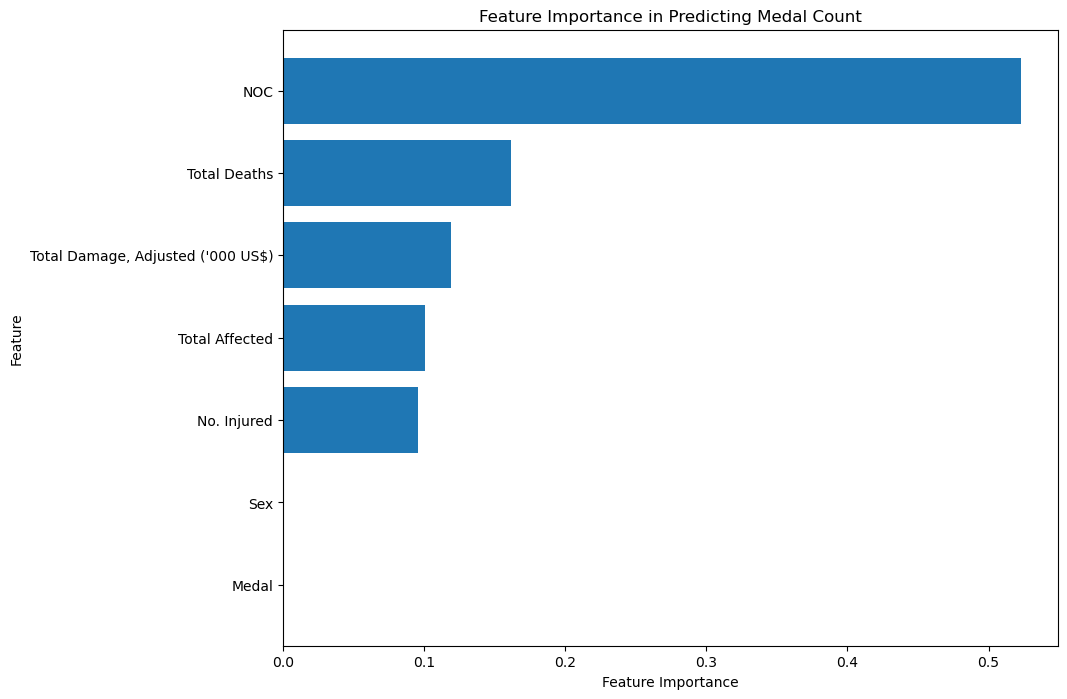

In [22]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
# Train the model
rf.fit(X_train, y_train)
# Get feature importances
importances = rf.feature_importances_
feature_names = features.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# Sort the features by importance
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
# Display the feature importance
print(feature_importance_df)
# Plot feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting Medal Count')
plt.gca().invert_yaxis()
plt.show()